In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import matplotlib.colors as mpc
import networkx
import progressbar
import astropy.cosmology as apc

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
# Slist = h5py.File('SatelliteList_V2_withAngles_n500.h5', 'r')
# Satellites = Slist['SatelliteList'][()]
# Centrals = Slist['SatelliteCentral'][()]
# CosCen = Slist['CosCen'][()]
# CosVel = Slist['CosVel'][()]
# #LzL = Slist['LZ_L'][()]
# Satellites.size

In [5]:
# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [6]:
#ok, now the serialized version of the get particles for each Satellite, lets see.
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [7]:
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

In [8]:
def getAllLastP(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    uniqueIDC = int(128*1e6+centralID)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []
    zlist = []
    SFRlist = []
    distlist = []
    z2, z1 = -1., -1.
    
    for mm, mmC in zip(mtree[1:], mtreeC[1:]): # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        snapC, iddC = split_unique_id(int(mmC))
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
#             # and the temperature
#             IE = sim['SnapNumber_{}/PartType0/InternalEnergy'.format(snap)][tempOff[0]:tempOff[1]]
#             Mass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][tempOff[0]:tempOff[1]]
#             Abund = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
#             ne1 = sim['SnapNumber_{}/PartType0/ElectronAbundance'.format(snap)][tempOff[0]:tempOff[1]]
#             val2 = tempFromMass(Mass, Abund, IE, ne1)
#             templist2.extend(list(val2))
            # and the metallicity
#             AbundatTime = sim['SnapNumber_{}/PartType0/Abundances'.format(snap)][tempOff[0]:tempOff[1]]
#             val = np.log10((AbundatTime[:,4]/FeMass)/(AbundatTime[:,6]/HMass)) - NfeNhe_sun
#             val = (AbundatTime[:,4]/FeMass)/(AbundatTime[:,6]/HMass)
#             templist.extend(list(val))
            zz = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
            zlist.extend([zz]*tempIds.size)
            
            # and the distance to the centre (of the galaxy in virial radius units)
            galP = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
            cenP = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddC]
            gro = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
            R200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][gro]
            
            defe = cenP - galP
            dist = np.sqrt(np.sum(defe**2.))/R200
            
            if dist<2.:
                z2 = zz
            if dist<1.:
                z1 = zz
            
            SFRs = sim['SnapNumber_{}/PartType0/StarFormationRate'.format(snap)][tempOff[0]:tempOff[1]]
            
            StarOffs = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
            StarMass = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][StarOffs[0]:StarOffs[1]]
            
            #SFR = np.sum(SFRs)/(np.sum(StarMass)*1e10)
            SFR = np.sum(SFRs)
            SFRlist.extend([SFR]*tempIds.size)
            distlist.extend([dist]*tempIds.size)
            
            Idlist.extend(list(tempIds))

    Idlist = np.array(Idlist)
    zlist = np.array(zlist)
    SFRlist = np.array(SFRlist)
    distlist = np.array(distlist)
    
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    zlist = zlist[Idunique]
    SFRlist = SFRlist[Idunique]
    distlist = distlist[Idunique]
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    # and temperature
    SurvIds_ = TdayTotalIDs[IndexT_]
    iidex = np.in1d(Idlist, SurvIds_)
    iidex_ = np.where(iidex)[0]
    zlist_, Idlist_ = zlist[iidex_], Idlist[iidex_]
    SFRlist_ = SFRlist[iidex_]
    distlist_ = distlist[iidex_]

    is1 = np.argsort(SurvIds_) # the target
    is2 = np.argsort(Idlist_)

    zorder = np.zeros(IndexT_.size)
    
    zorder[is1] = zlist_[is2]
    
    SFRorder = np.zeros(IndexT_.size)
    SFRorder[is1] = SFRlist_[is2]

    distorder = np.zeros(IndexT_.size)
    distorder[is1] = distlist_[is2]
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_]
    GassAbundances = sim['SnapNumber_128/PartType0/Abundances'][IndexT_]
    
    return GasMasses, GassAbundances, zorder, SFRorder, distorder, z1, z2

In [9]:
# ok, lets test this
GasMasses, GassAbundances, zorder, SFRorder, distlist, z1, z2 = getAllLastP(4338, 4337)

zu = np.unique(zorder)
tzu = Cosmo.lookback_time(zu).value

Mass = []
SFRor = []
dist = []

for z in zu:
    ii = np.where(zorder==z)[0]
    GMass = np.sum(GasMasses[ii])
    SFRt = SFRorder[ii[0]]
    distt = np.mean(distlist[ii])
    Mass.append(GMass)
    SFRor.append(SFRt)
    dist.append(distt)
    
Mass = np.array(Mass)*1e10
SFRor = np.array(SFRor)
dist = np.array(dist)

print(dist)

[1.04663968e+00 1.06555665e+00 1.08093321e+00 1.08649063e+00
 1.08060229e+00 1.06552768e+00 1.03388000e+00 9.87218797e-01
 9.29070413e-01 8.57014239e-01 7.68319964e-01 6.52104855e-01
 5.16931653e-01 3.49849582e-01 1.31929934e-01 2.21827388e-01
 4.55760986e-01 6.74754083e-01 8.70849013e-01 1.05503309e+00
 1.21949565e+00 1.37940431e+00 1.51367581e+00 1.64206004e+00
 1.75770342e+00 1.85953784e+00 1.95197439e+00 2.05518579e+00
 2.16997528e+00 2.28631091e+00 2.40894055e+00 2.48510218e+00
 2.57832623e+00 2.65857625e+00 2.74218702e+00 2.78779984e+00
 2.89272094e+00 2.98129749e+00 3.13579893e+00 3.25355196e+00
 3.40949535e+00 3.61343789e+00 3.83906221e+00 4.04892492e+00
 4.29128027e+00 4.62992239e+00 4.86984062e+00 4.78770113e+00
 4.99214745e+00 5.16918373e+00 5.15940762e+00 5.41343927e+00
 5.64708519e+00 6.17960882e+00 6.24221373e+00 6.41225958e+00
 6.53401899e+00 6.61377001e+00 6.71248150e+00 6.83651781e+00
 6.97678518e+00 7.13005877e+00 7.27596807e+00 7.38910055e+00
 7.58273268e+00 7.799981

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


Text(0, 0.5, 'log(Gas Mass ejected/$M_{\\odot}$)')

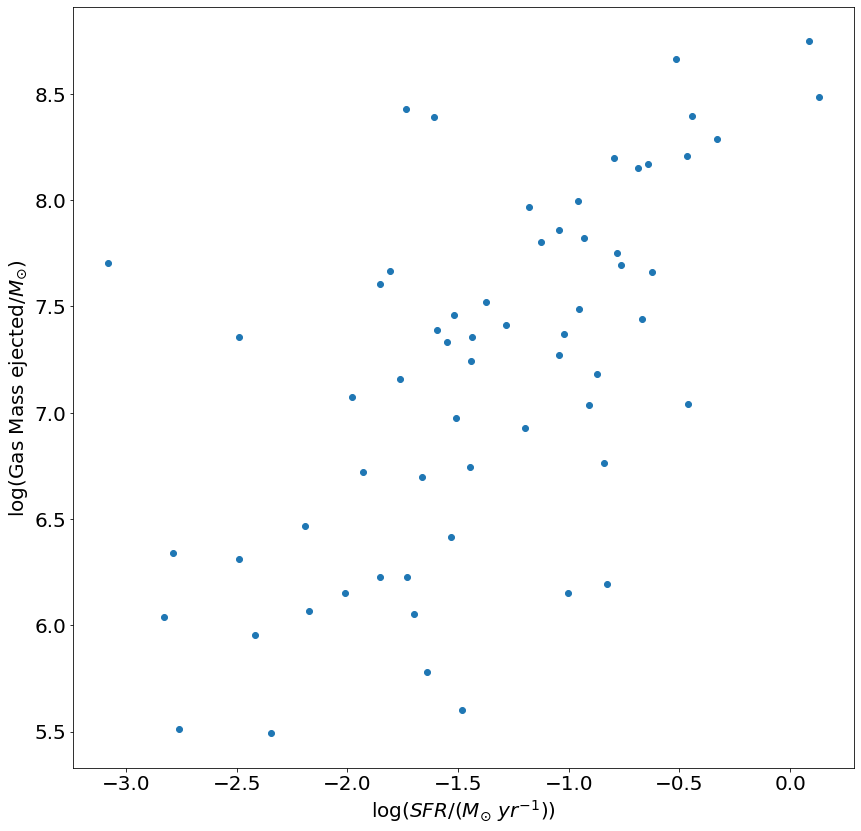

In [10]:
# so, firts, just mass vs SFR or so.

pl.figure(figsize=(14,14))

pl.scatter(np.log10(SFRor), np.log10(Mass), marker='o')

#pl.yscale('log')
# pl.xscale('log')

# pl.xlabel('log(sSFR/yr⁻¹)')
# pl.ylabel('log(Gas Mass ejected/M_sun)')

pl.xlabel('$\log(SFR/(M_{\odot}\,\,yr^{-1}))$')
pl.ylabel('log(Gas Mass ejected/$M_{\odot}$)')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


0.24339225775468964 0.38219559019532867


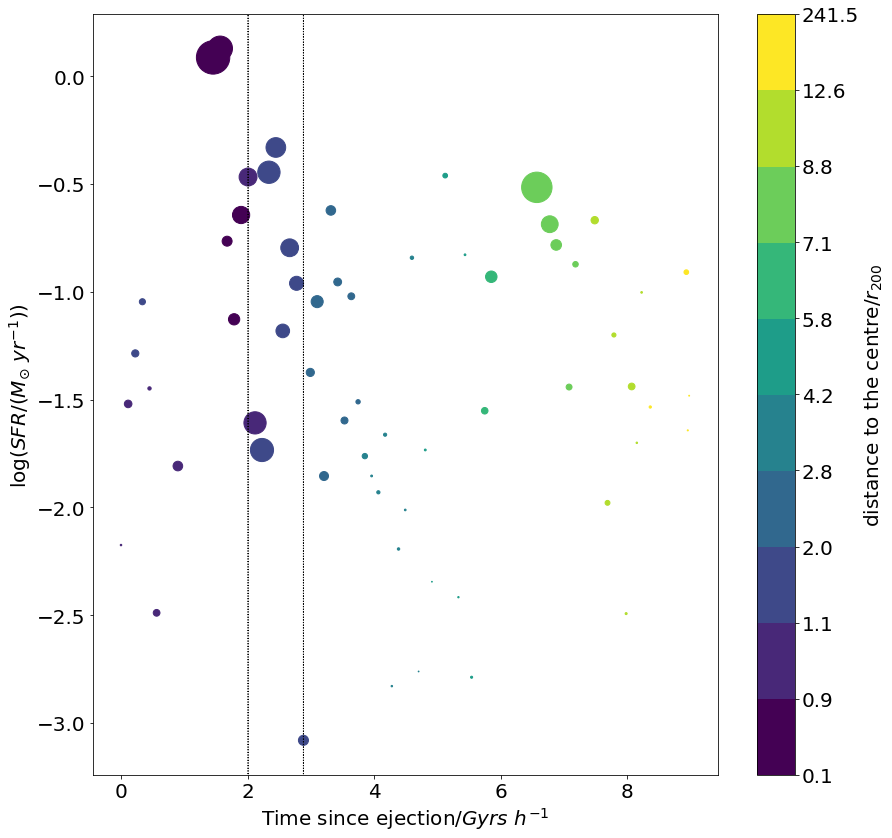

In [11]:
pl.figure(figsize=(14,14))

vaper = np.linspace(0, 100, 11)
papels = np.percentile(dist, vaper)
norm = mpc.BoundaryNorm(boundaries=papels, ncolors=256)

pl.scatter(tzu, np.log10(SFRor), s=Mass/5e5, c=dist, norm=norm)

tz1 = Cosmo.lookback_time(z1).value
tz2 = Cosmo.lookback_time(z2).value

pl.arrow(tz1, -100., 0., 200, color='black', ls=':')
pl.arrow(tz2, -100., 0., 200, color='black', ls=':')

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

pl.ylabel('$\log(SFR/(M_{\odot}\,\,yr^{-1}))$')
# pl.ylabel('log(sSFR/yr⁻¹)')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

In [12]:
# ok, lets test this
GasMasses1, GassAbundances1, zorder1, SFRorder1, distlist1, z1_1, z2_1 = getAllLastP(4341, 4337)

zu1 = np.unique(zorder1)
tzu1 = Cosmo.lookback_time(zu1).value

Mass1 = []
SFRor1 = []
dist1 = []

for z in zu1:
    ii = np.where(zorder1==z)[0]
    GMass = np.sum(GasMasses1[ii])
    SFRt = SFRorder1[ii[0]]
    distt = distlist1[ii[0]]
    Mass1.append(GMass)
    SFRor1.append(SFRt)
    dist1.append(distt)
    
Mass1 = np.array(Mass1)*1e10
SFRor1 = np.array(SFRor1)
dist1 = np.array(dist1)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'log(Gas Mass ejected/$M_{\\odot}$)')

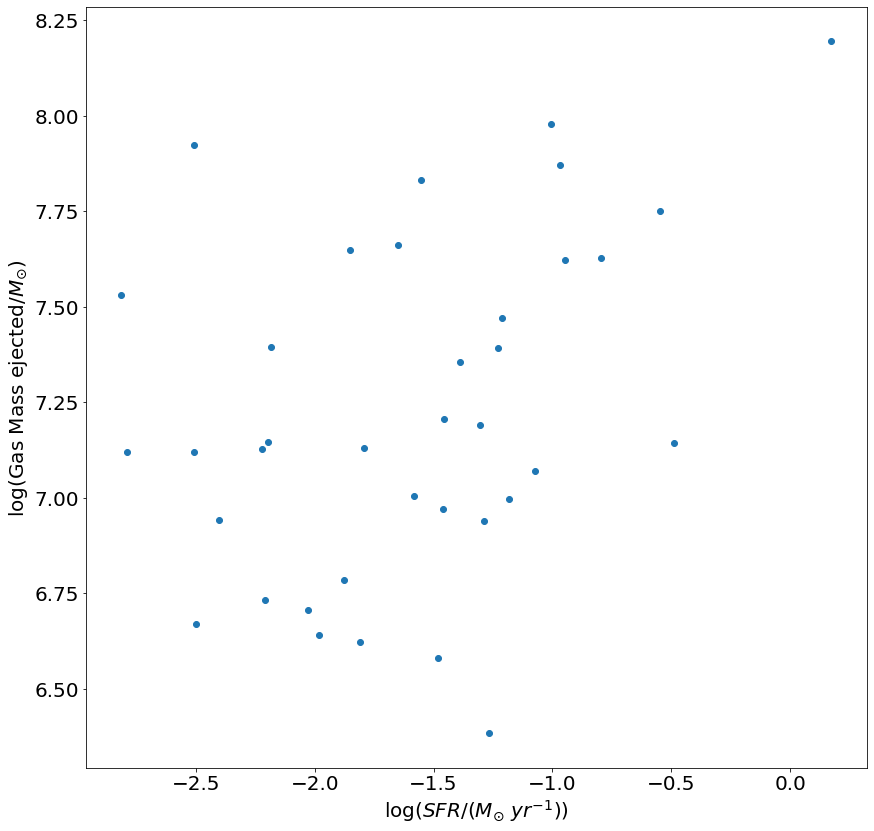

In [13]:
pl.figure(figsize=(14,14))

pl.scatter(np.log10(SFRor1), np.log10(Mass1), marker='o')

#pl.yscale('log')
# pl.xscale('log')

# pl.xlabel('log(SFR/(M_sun/yr))')
# pl.xlabel('log(sSFR/yr⁻¹)')
# pl.ylabel('log(Gas Mass ejected/M_sun)')

pl.xlabel('$\log(SFR/(M_{\odot}\,\,yr^{-1}))$')
pl.ylabel('log(Gas Mass ejected/$M_{\odot}$)')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


0.24339225775468964 0.38219559019532867
0.2594730228456261 0.3634722484955717


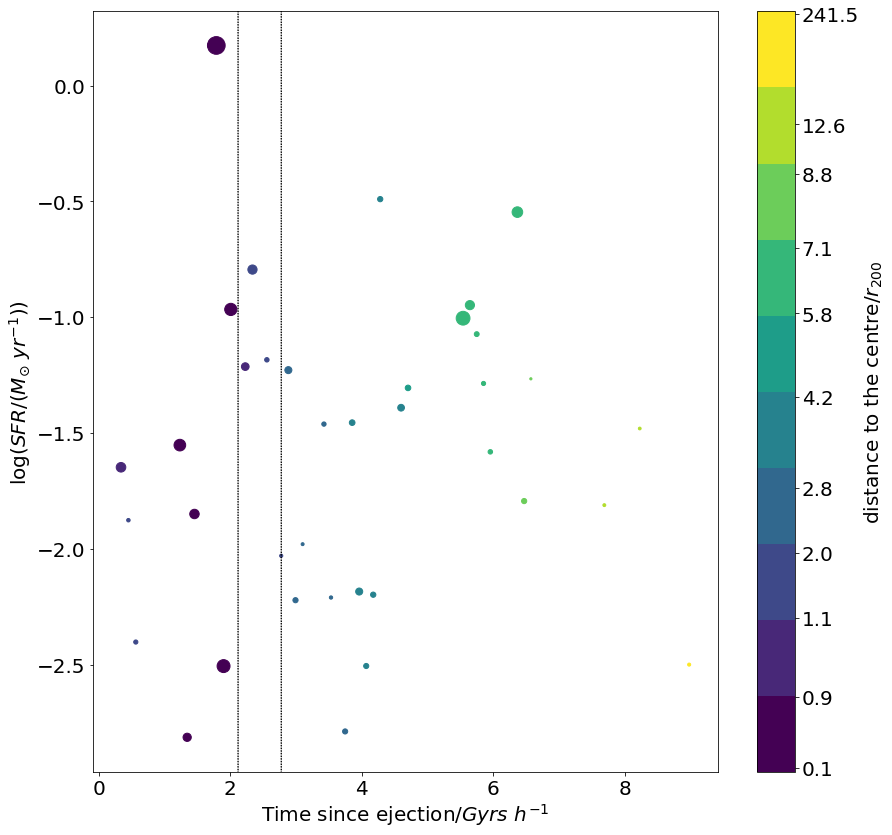

In [14]:
pl.figure(figsize=(14,14))

papels1 = np.percentile(dist1, vaper)
norm1 = mpc.BoundaryNorm(boundaries=papels1, ncolors=256)

pl.scatter(tzu1, np.log10(SFRor1), s=Mass1/5e5, c=dist1, norm=norm1)

tz1_1 = Cosmo.lookback_time(z1_1).value
tz2_1 = Cosmo.lookback_time(z2_1).value

pl.arrow(tz1_1, -100., 0., 200, color='black', ls=':')
pl.arrow(tz2_1, -100., 0., 200, color='black', ls=':')

# bar = pl.colorbar(label='distance to the centre/r_200')
# bar.set_ticks(papels1)

# # pl.ylabel('log(SFR/(M_sun/yr))')
# pl.ylabel('log(sSFR/yr⁻¹)')
# pl.xlabel('Time since ejection/Gyrs')


bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

pl.ylabel('$\log(SFR/(M_{\odot}\,\,yr^{-1}))$')
# pl.ylabel('log(sSFR/yr⁻¹)')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)
print(z1_1, z2_1)

In [15]:
GasMasses2, GassAbundances2, zorder2, SFRorder2, distlist2, z1_2, z2_2 = getAllLastP(4470, 4469)

zu2 = np.unique(zorder2)
tzu2 = Cosmo.lookback_time(zu2).value

Mass2 = []
SFRor2 = []
dist2 = []

for z in zu2:
    ii = np.where(zorder2==z)[0]
    GMass = np.sum(GasMasses2[ii])
    SFRt = SFRorder2[ii[0]]
    distt = distlist2[ii[0]]
    Mass2.append(GMass)
    SFRor2.append(SFRt)
    dist2.append(distt)
    
Mass2 = np.array(Mass2)*1e10
SFRor2 = np.array(SFRor2)
dist2 = np.array(dist2)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'log(Gas Mass ejected/$M_{\\odot}$)')

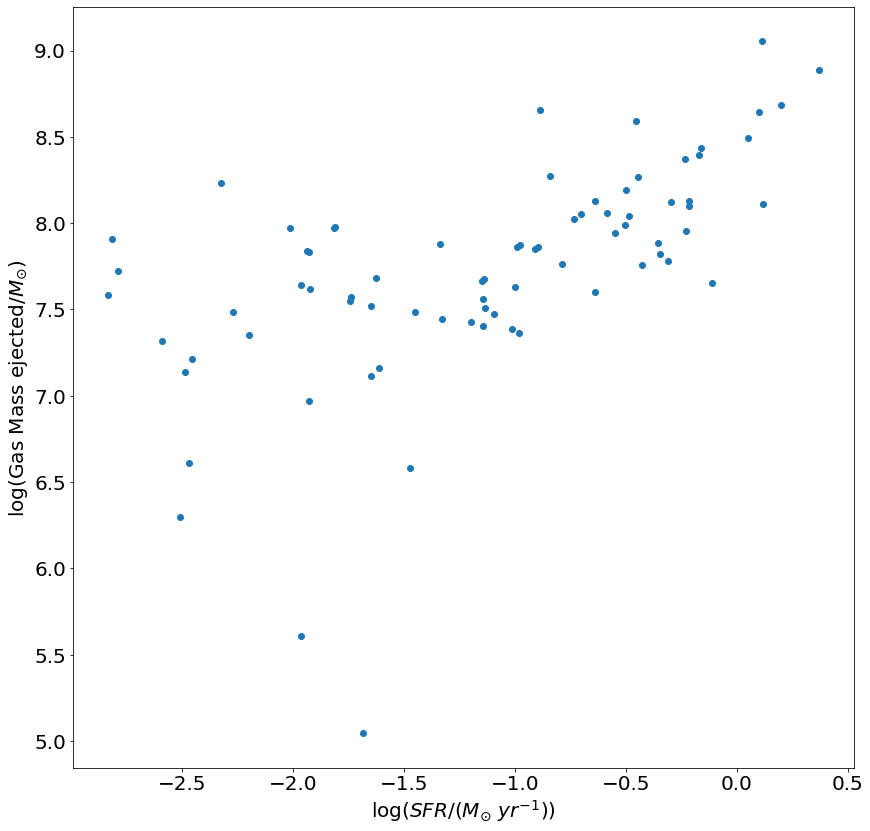

In [16]:
pl.figure(figsize=(14,14))

pl.scatter(np.log10(SFRor2), np.log10(Mass2), marker='o')

#pl.yscale('log')
# pl.xscale('log')

# pl.xlabel('log(SFR/(M_sun/yr))')
# pl.xlabel('log(sSFR/yr⁻¹)')
# pl.ylabel('log(Gas Mass ejected/M_sun)')

pl.xlabel('$\log(SFR/(M_{\odot}\,\,yr^{-1}))$')
pl.ylabel('log(Gas Mass ejected/$M_{\odot}$)')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


0.24339225775468964 0.38219559019532867


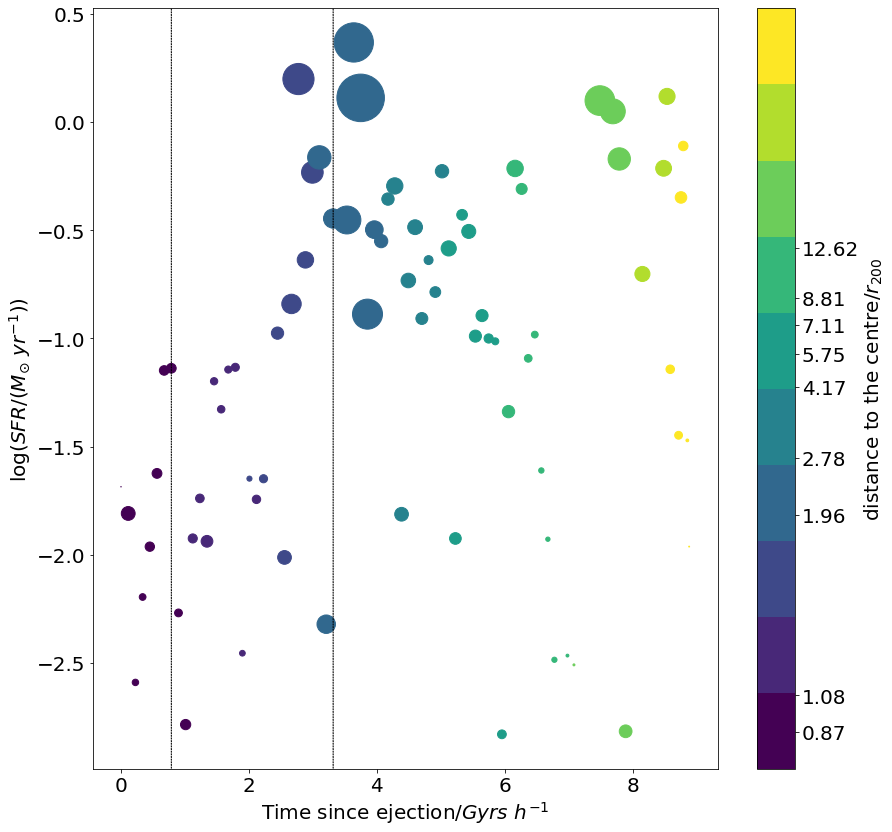

In [17]:
pl.figure(figsize=(14,14))


papels2 = np.percentile(dist2, vaper)
norm2 = mpc.BoundaryNorm(boundaries=papels2, ncolors=256)

pl.scatter(tzu2, np.log10(SFRor2), s=Mass2/5e5, c=dist2, norm=norm2)

tz1_2 = Cosmo.lookback_time(z1_2).value
tz2_2 = Cosmo.lookback_time(z2_2).value

pl.arrow(tz1_2, -100., 0., 200, color='black', ls=':')
pl.arrow(tz2_2, -100., 0., 200, color='black', ls=':')

# bar = pl.colorbar(label='distance to the centre/r_200')
# bar.set_ticks(papels2)

# # pl.ylabel('log(SFR/(M_sun/yr))')
# pl.ylabel('log(sSFR/yr⁻¹)')
# pl.xlabel('Time since ejection/Gyrs')

# print(z1_2, z2_2)

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

pl.ylabel('$\log(SFR/(M_{\odot}\,\,yr^{-1}))$')
# pl.ylabel('log(sSFR/yr⁻¹)')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

In [18]:
GasMasses3, GassAbundances3, zorder3, SFRorder3, distlist3, z1_3, z2_3 = getAllLastP(4474, 4469)

zu3 = np.unique(zorder3)
tzu3 = Cosmo.lookback_time(zu3).value

Mass3 = []
SFRor3 = []
dist3 = []

for z in zu3:
    ii = np.where(zorder3==z)[0]
    GMass = np.sum(GasMasses3[ii])
    SFRt = SFRorder3[ii[0]]
    distt = distlist3[ii[0]]
    Mass3.append(GMass)
    SFRor3.append(SFRt)
    dist3.append(distt)
    
Mass3 = np.array(Mass3)*1e10
SFRor3 = np.array(SFRor3)
dist3 = np.array(dist3)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'log(Gas Mass ejected/$M_{\\odot}$)')

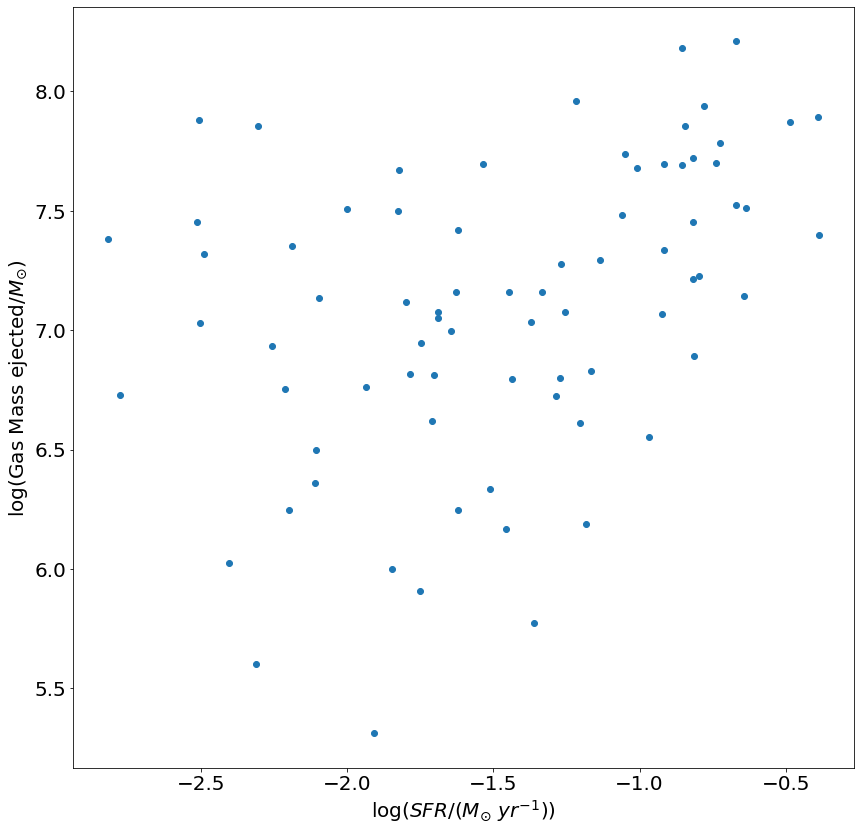

In [19]:
pl.figure(figsize=(14,14))

pl.scatter(np.log10(SFRor3), np.log10(Mass3), marker='o')

#pl.yscale('log')
# pl.xscale('log')

# pl.xlabel('log(SFR/(M_sun/yr))')
# pl.xlabel('log(sSFR/yr⁻¹)')
# pl.ylabel('log(Gas Mass ejected/M_sun)')

pl.xlabel('$\log(SFR/(M_{\odot}\,\,yr^{-1}))$')
pl.ylabel('log(Gas Mass ejected/$M_{\odot}$)')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


0.24339225775468964 0.38219559019532867


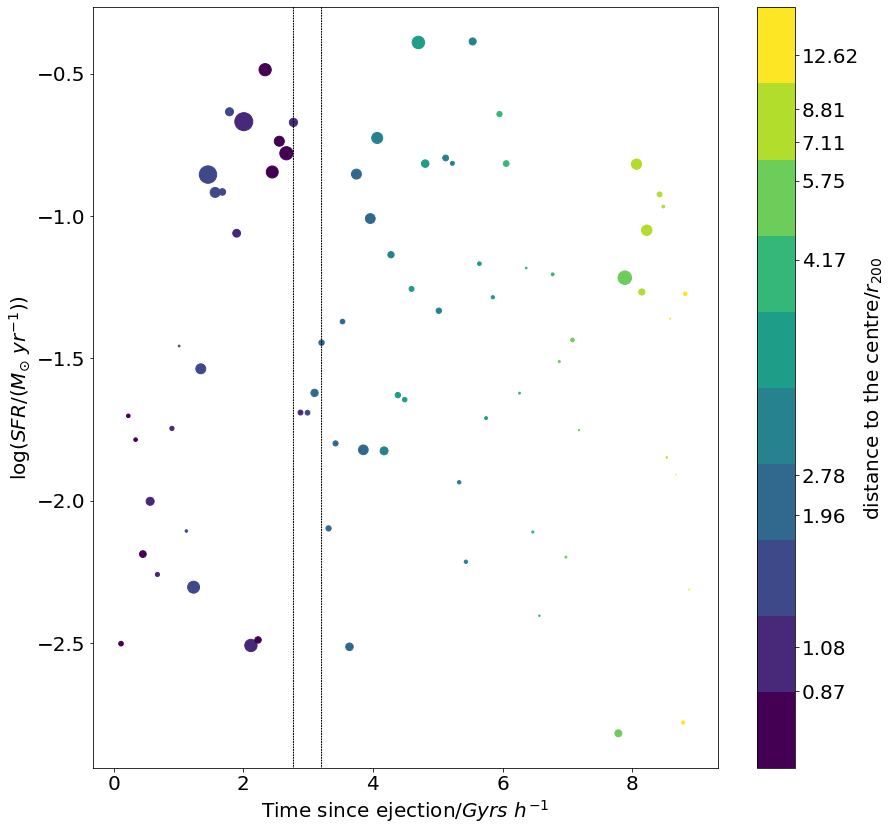

In [20]:
pl.figure(figsize=(14,14))

papels3 = np.percentile(dist3, vaper)
norm3 = mpc.BoundaryNorm(boundaries=papels3, ncolors=256)

pl.scatter(tzu3, np.log10(SFRor3), s=Mass3/5e5, c=dist3, norm=norm3)

tz1_3 = Cosmo.lookback_time(z1_3).value
tz2_3 = Cosmo.lookback_time(z2_3).value

pl.arrow(tz1_3, -100., 0., 200, color='black', ls=':')
pl.arrow(tz2_3, -100., 0., 200, color='black', ls=':')

# bar = pl.colorbar(label='distance to the centre/r_200')
# bar.set_ticks(papels3)

# # pl.ylabel('log(SFR/(M_sun/yr))')
# pl.ylabel('log(sSFR/yr⁻¹)')
# pl.xlabel('Time since ejection/Gyrs')

# print(z1_3, z2_3)

bar = pl.colorbar(label='distance to the centre/$r_{200}$')
bar.set_ticks(papels)

pl.ylabel('$\log(SFR/(M_{\odot}\,\,yr^{-1}))$')
# pl.ylabel('log(sSFR/yr⁻¹)')
pl.xlabel('Time since ejection/$Gyrs\,\,h^{-1}$')

print(z1, z2)

In [21]:
sim['SnapNumber_128/PartType0/StarFormationRate'].attrs['description_units']

'$M_\\odot yr^{-1}$'

In [22]:
sim['SnapNumber_128/PartType4/Masses'].attrs['description_units']

'$10^{10}  h^{-1} M_\\odot$'